In [1]:
import numpy as np
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [2]:
image_array = np.load('../input/product-250-amazon/image_array_250.npy')
label_array = np.load('../input/product-250-amazon/label_array_250.npy')

In [3]:
train_images, val_images, train_labels, val_labels=train_test_split(image_array, label_array,
                                                                      test_size=0.3, random_state=42)
val_images,test_images, val_labels, test_labels=train_test_split(val_images, val_labels,
                                                                      test_size=0.33, random_state=42)

train_images, test_images, val_images = train_images / 255, test_images / 255,val_images / 255

print('Number of   training samples : {}'.format(train_images.shape[0]))
print('Number of validation samples : {}'.format(val_images.shape[0]))
print('Number of       test samples : {}'.format(test_images.shape[0]))

Number of   training samples : 3498
Number of validation samples : 1005
Number of       test samples : 495


In [4]:
lr = 0.00001
epoch = 15
batch_size = 32

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [6]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

        model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2), strides = 2),
        Flatten(),
        Dense(20, activation='softmax')])
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
model.summary()

2022-10-04 07:03:33.665917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 07:03:33.767528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 07:03:33.768401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 07:03:33.769940: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                92180     
Total params: 20,116,564
Trainable params: 4,811,796
Non-trainable params: 15,304,768
_________________________________________________________________


In [7]:
# model = VGG19(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=(224,224,3),
#     pooling='max',
#     classes=20,
#     classifier_activation='softmax'
# )
# model.compile(optimizer=Adam(learning_rate = 0.00001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
# model.summary()

In [8]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.3, min_lr=0.000001)

In [9]:
history = model.fit(train_images, train_labels, batch_size = batch_size , epochs = epoch, 
                    validation_data = (val_images,  val_labels),callbacks = [learning_rate_reduction])

2022-10-04 07:03:40.272630: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2106187776 exceeds 10% of free system memory.
2022-10-04 07:03:42.926822: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2106187776 exceeds 10% of free system memory.
2022-10-04 07:03:44.659429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-10-04 07:03:46.157640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 [==============================] - ETA: 0s - loss: 2.4162 - accuracy: 0.2962

2022-10-04 07:04:05.829688: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 605122560 exceeds 10% of free system memory.
2022-10-04 07:04:06.596018: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 605122560 exceeds 10% of free system memory.


110/110 [==============================] - 26s 146ms/step - loss: 2.4162 - accuracy: 0.2962 - val_loss: 2.0580 - val_accuracy: 0.3841
Epoch 2/15
110/110 [==============================] - 11s 105ms/step - loss: 1.3861 - accuracy: 0.6018 - val_loss: 2.0046 - val_accuracy: 0.4338
Epoch 3/15
110/110 [==============================] - 12s 109ms/step - loss: 0.7371 - accuracy: 0.8305 - val_loss: 1.8877 - val_accuracy: 0.4617
Epoch 4/15
110/110 [==============================] - 11s 104ms/step - loss: 0.3179 - accuracy: 0.9577 - val_loss: 1.9643 - val_accuracy: 0.4537
Epoch 5/15
110/110 [==============================] - 11s 104ms/step - loss: 0.1342 - accuracy: 0.9900 - val_loss: 2.0479 - val_accuracy: 0.4597

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 6/15
110/110 [==============================] - 11s 105ms/step - loss: 0.0540 - accuracy: 0.9980 - val_loss: 1.9776 - val_accuracy: 0.4826
Epoch 7/15
110/110 [==============================] - 11s 1

In [10]:
print("Loss of the model is - " , model.evaluate(test_images, test_labels)[0])
print("Accuracy of the model is - " , model.evaluate(test_images, test_labels)[1]*100 , "%")

2022-10-04 07:07:07.539398: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 298045440 exceeds 10% of free system memory.


16/16 [==============================] - 3s 175ms/step - loss: 2.0187 - accuracy: 0.4869
Loss of the model is -  2.018686532974243
16/16 [==============================] - 1s 74ms/step - loss: 2.0187 - accuracy: 0.4869
Accuracy of the model is -  48.6868679523468 %


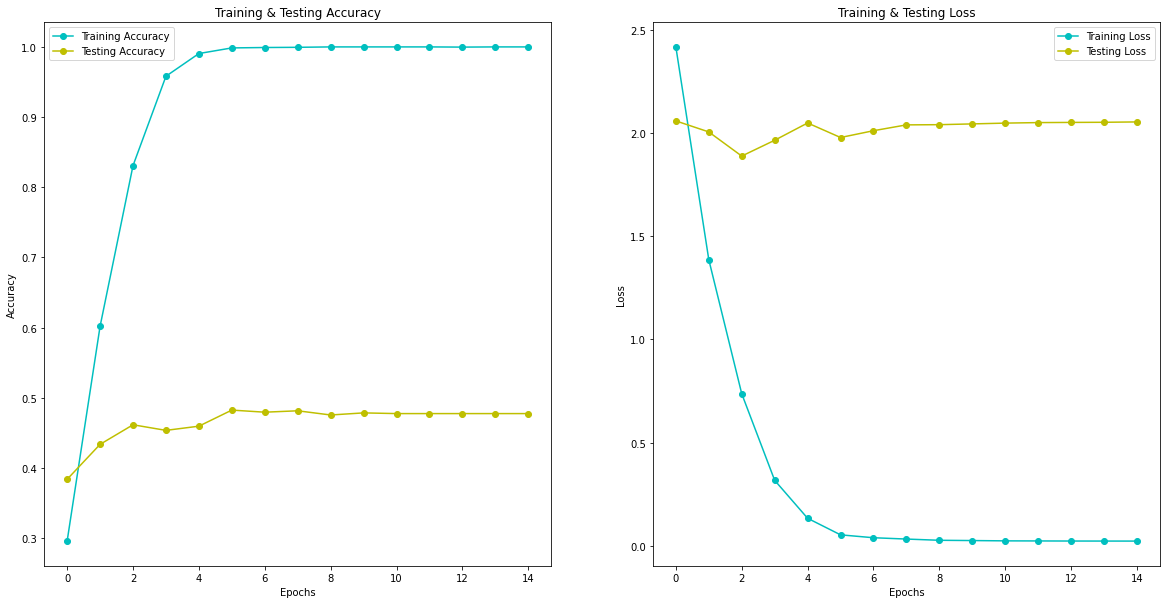

In [11]:
epochs = [i for i in range(epoch)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'co-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-', label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'c-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o', label= 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [13]:
model.save('vgg19.h5')